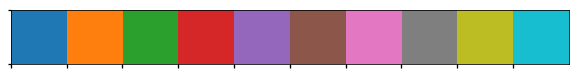

In [1]:
%matplotlib inline
%load_ext watermark
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.animation import FuncAnimation
from tempfile import NamedTemporaryFile
from IPython.display import HTML
import seaborn as sns
import numpy as np
import six
import tensorflow as tf

plt.style.use('seaborn-talk')
sns.set_context("talk", font_scale=1.4)
# sns.set_palette("colorblind")
sess = ed.get_session()

sns.palplot(sns.color_palette())
# this can be done only before using Edward
ed.set_seed(42)

In [2]:
#!/usr/bin/env python
"""Bayesian neural network using variational inference
(see, e.g., Blundell et al. (2015); Kucukelbir et al. (2016)).
Inspired by autograd's Bayesian neural network example.
This example prettifies some of the tensor naming for visualization in
TensorBoard. To view TensorBoard, run `tensorboard --logdir=log`.
References
----------
http://edwardlib.org/tutorials/bayesian-neural-network
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf

from edward.models import Normal


def build_toy_dataset(N=40, noise_std=0.1):
  D = 1
  X = np.concatenate([np.linspace(0, 2, num=N / 2),
                      np.linspace(6, 8, num=N / 2)])
  y = np.cos(X) + np.random.normal(0, noise_std, size=N)
  X = (X - 4.0) / 4.0
  X = X.reshape((N, D))
  return X, y


def neural_network(X):
  h = tf.tanh(tf.matmul(X, W_0) + b_0)
  h = tf.tanh(tf.matmul(h, W_1) + b_1)
  h = tf.matmul(h, W_2) + b_2
  return tf.reshape(h, [-1])


ed.set_seed(42)

N = 40  # number of data points
D = 1   # number of features

# DATA
X_train, y_train = build_toy_dataset(N)

# MODEL
with tf.name_scope("model"):
  W_0 = Normal(loc=tf.zeros([D, 10]), scale=tf.ones([D, 10]), name="W_0")
  W_1 = Normal(loc=tf.zeros([10, 10]), scale=tf.ones([10, 10]), name="W_1")
  W_2 = Normal(loc=tf.zeros([10, 1]), scale=tf.ones([10, 1]), name="W_2")
  b_0 = Normal(loc=tf.zeros(10), scale=tf.ones(10), name="b_0")
  b_1 = Normal(loc=tf.zeros(10), scale=tf.ones(10), name="b_1")
  b_2 = Normal(loc=tf.zeros(1), scale=tf.ones(1), name="b_2")

  X = tf.placeholder(tf.float32, [N, D], name="X")
  y = Normal(loc=neural_network(X), scale=0.1 * tf.ones(N), name="y")

# INFERENCE
with tf.name_scope("posterior"):
  with tf.name_scope("qW_0"):
    qW_0 = Normal(loc=tf.Variable(tf.random_normal([D, 10]), name="loc"),
                  scale=tf.nn.softplus(
                      tf.Variable(tf.random_normal([D, 10]), name="scale")))
  with tf.name_scope("qW_1"):
    qW_1 = Normal(loc=tf.Variable(tf.random_normal([10, 10]), name="loc"),
                  scale=tf.nn.softplus(
                      tf.Variable(tf.random_normal([10, 10]), name="scale")))
  with tf.name_scope("qW_2"):
    qW_2 = Normal(loc=tf.Variable(tf.random_normal([10, 1]), name="loc"),
                  scale=tf.nn.softplus(
                      tf.Variable(tf.random_normal([10, 1]), name="scale")))
  with tf.name_scope("qb_0"):
    qb_0 = Normal(loc=tf.Variable(tf.random_normal([10]), name="loc"),
                  scale=tf.nn.softplus(
                      tf.Variable(tf.random_normal([10]), name="scale")))
  with tf.name_scope("qb_1"):
    qb_1 = Normal(loc=tf.Variable(tf.random_normal([10]), name="loc"),
                  scale=tf.nn.softplus(
                      tf.Variable(tf.random_normal([10]), name="scale")))
  with tf.name_scope("qb_2"):
    qb_2 = Normal(loc=tf.Variable(tf.random_normal([1]), name="loc"),
                  scale=tf.nn.softplus(
                      tf.Variable(tf.random_normal([1]), name="scale")))

inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1,
                     W_2: qW_2, b_2: qb_2}, data={X: X_train, y: y_train})


/Users/chinmaykulkarni/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/Users/chinmaykulkarni/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


In [3]:
inference.run(logdir='log')

1000/1000 [100%] ██████████████████████████████ Elapsed: 11s | Loss: 664.360


In [12]:
h = sess.run(y,{X:X_train})

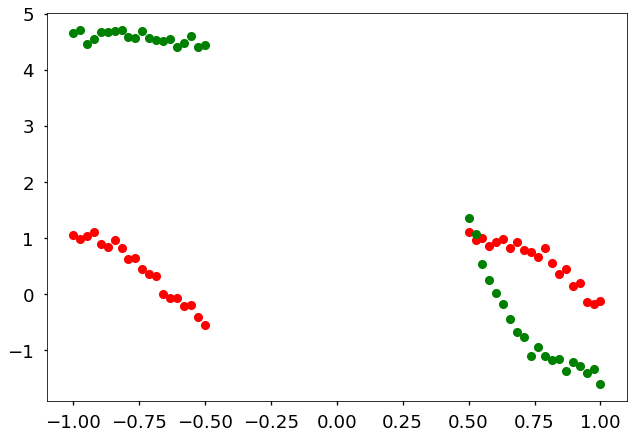

In [16]:
plt.plot(X_train,y_train,"ro")
plt.plot(X_train,h,"go")
